In [5]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
import joblib
from statistics import median

import pyfinancialdata
import trade_functions
import pandas_techinal_indicators

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [7]:
# A variable for the name of this notebook
notebook_name = os.path.splitext(os.path.basename(NOTEBOOK_FULL_PATH))[0]

In [8]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='EUR_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='24h',
    price_calculation='close',
)

In [9]:
environment_columns = ['price', 'RSI_14', 'ATR_7', 'ADX_7_14']

def add_features(df):
    '''
    Adds feature columns to a pandas price data df
    '''
    df.reset_index(inplace=True)
    
    df = pandas_techinal_indicators.relative_strength_index(df, 14)
    df = pandas_techinal_indicators.average_true_range(df, 7)
    df = pandas_techinal_indicators.average_directional_movement_index(df, 7, 14)
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [10]:
price_data = add_features(price_data.copy())

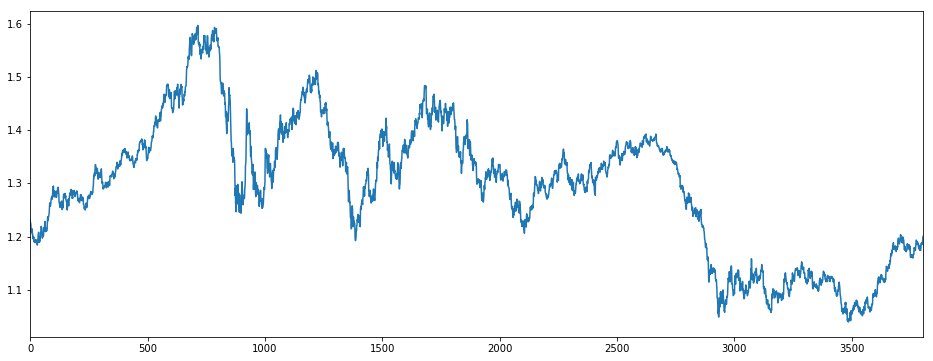

In [11]:
price_data['price'].plot(figsize=(16,6))

In [12]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 2536, test size 1268


In [13]:
episode=1000
batch_size=10

In [14]:
train_data.head(5)

,index,date,close,high,low,open,price,RSI_14,ATR_7,ADX_7_14
0,0,2006-01-23,1.2304,1.23220,1.21640,1.2167,1.2304,0.758386,0.009556,0.343613
1,1,2006-01-24,1.2265,1.23110,1.22572,1.2304,1.2265,0.758386,0.008510,0.365054
2,2,2006-01-25,1.2244,1.23232,1.22362,1.2264,1.2244,0.699771,0.008557,0.327176
3,3,2006-01-26,1.2213,1.22692,1.21980,1.2244,1.2213,0.602097,0.008197,0.343388
4,4,2006-01-27,1.2094,1.22352,1.20876,1.2213,1.2094,0.410861,0.009840,0.357055


In [15]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,379
Trainable params: 1,379
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [16]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)



....................
episode: 20/1000
median profit: 994 pips, median trade count: 155
....................
episode: 40/1000
median profit: 1976 pips, median trade count: 194
....................
episode: 60/1000
median profit: 4292 pips, median trade count: 229
....................
episode: 80/1000
median profit: 4878 pips, median trade count: 262
....................
episode: 100/1000
median profit: 5365 pips, median trade count: 286
....................
episode: 120/1000
median profit: 5660 pips, median trade count: 301
....................
episode: 140/1000
median profit: 6218 pips, median trade count: 301
....................
episode: 160/1000
median profit: 6232 pips, median trade count: 301
....................
episode: 180/1000
median profit: 6913 pips, median trade count: 294
....................
episode: 200/1000
median profit: 7366 pips, median trade count: 286
....................
episode: 220/1000
median profit: 7721 pips, median trade count: 280
....................
epi

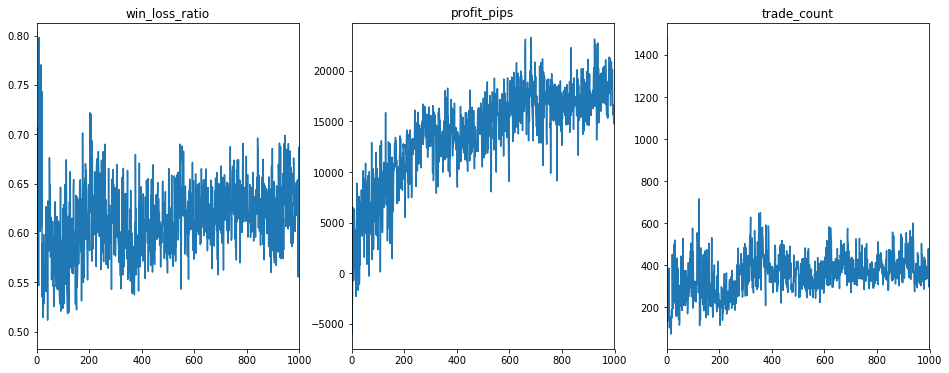

In [17]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [18]:
joblib.dump(agent, '{0}.pkl'.format(notebook_name)) 

['24h-EUR_USD.pkl']

## Test

In [19]:
# Uncomment to load agent from file 
# agent = joblib.load('{0}.pkl'.format(notebook_name))  

In [20]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

In [21]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [22]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))

Median profit: 1497.3249999998238 pips


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12fb92050>]],
      dtype=object)

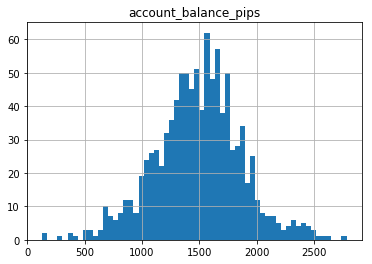

In [23]:
plt.figure(figsize=(16,6))
test_results.hist(column='account_balance_pips', bins=60)

## Analyse positions on test data

In [24]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data.copy(),
    environment_columns=environment_columns,
    save_positions_on_df=True,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n

In [25]:
state = env.reset()
state = scaler.transform([state])
for i in range(env.n_step):
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    if done:
        break

In [26]:
env._stats()

{'trade_count': 349,
 'win_loss_ratio': 0.5358166189111748,
 'account_balance': 0.20117499999998212,
 'unrealised_pl': -0.040385000000000115}

In [27]:
position_data = env.price_data.copy()

In [28]:
position_data['position'] = position_data['position'] - 1

In [29]:
trades = trade_functions.create_trades_from_positions(position_data.copy())

351 positions to plot...


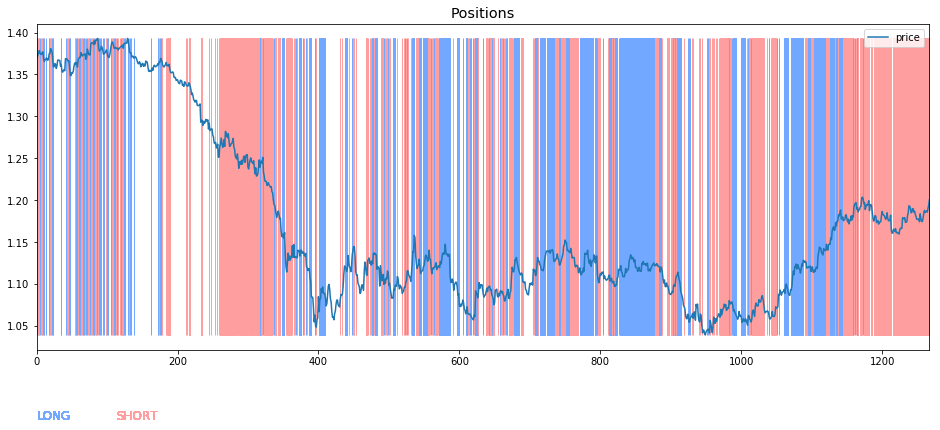

In [30]:
trade_functions.show_positions_on_price_plot(position_data.copy())

In [31]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 53.85%
Ratio of long to short positions: 0.85
Median profit: 0.0
Total profit: 0.18703999999999854
Median position length: 1.0
Number of trades: 351


In [32]:
trades

,enter_date,enter_price,exit_date,exit_price,position_length,position,profit,profitable,account_balance
0,2013-12-06,1.37062,2013-12-08,1.37066,1,NaN,NaN,False,NaN
1,2013-12-08,1.37066,2013-12-09,1.37370,1,1.0,0.00304,True,0.00304
2,2013-12-09,1.37370,2013-12-10,1.37642,1,-1.0,-0.00272,False,0.00032
3,2013-12-10,1.37642,2013-12-11,1.37852,1,1.0,0.00210,True,0.00242
4,2013-12-11,1.37852,2013-12-12,1.37499,1,-1.0,0.00353,True,0.00595
...,...,...,...,...,...,...,...,...,...
346,2017-09-11,1.19580,2017-09-21,1.19448,9,-1.0,0.00132,True,0.19745
347,2017-09-22,1.19478,2017-09-26,1.17844,3,-1.0,0.01634,True,0.21379
348,2017-09-27,1.17495,2017-10-27,1.16080,26,-1.0,0.01415,True,0.22794
349,2017-10-29,1.16055,2017-11-06,1.16114,7,-1.0,-0.00059,False,0.22735


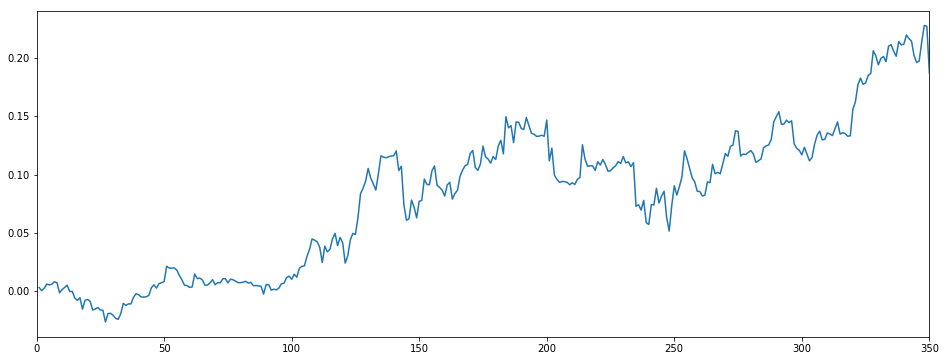

In [33]:
# Plot account balance
trades['account_balance'].plot(figsize=(16,6))

## Show distribution of maximum drawdown

Median drawdown: -0.11850000000000072


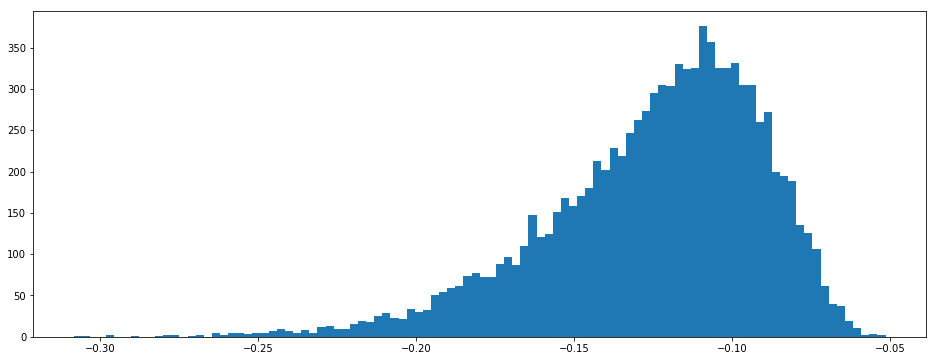

In [34]:
max_drawdown_results = trade_functions.plot_max_drawdown_distribution(trades.copy())
plt.figure(figsize=(16,6))
plt.hist(max_drawdown_results, bins=100);